In [ ]:
# default_exp vpu

In [ ]:
# export
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

import numpy as np

from easydict import EasyDict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from multiinstance.nnpu import getPosterior

from dist_curve.transforms import getOptimalTransform

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as KB
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import summary
import tensorflow.keras.backend as K
import tensorflow as tf

from multiinstance.nnpu import batch

from tqdm.notebook import trange

from multiinstance.nnpu import getPosterior

# Data

In [ ]:
def generateParams(nClusters, nComps, dim,aucpn_range=[0.8,0.85]):
    posMeans,posCovs,negMeans,negCovs,dgs =[], [],[],[],[]
    for comp in range(nClusters):
        dg = GaussianMixtureDataGenerator(dim,nComps,aucpn_range,1000,10000)
        pos,neg = dg.components_pos[0], dg.components_neg[0]
        r = np.zeros(dim)
        for _ in range(1):
            r += np.random.normal(loc=0,scale=10,size=dim)
        posMeans.append(pos.mean+r)
        posCovs.append(pos.cov)
        negMeans.append(neg.mean+r)
        negCovs.append(neg.cov)
        dgs.append(dg)
    val = EasyDict
    val.posMeans = posMeans
    val.posCovs = posCovs
    val.negMeans = negMeans
    val.negCovs = negCovs
    val.dgs = dgs
    return val

In [ ]:
args = EasyDict()
args.nClusters = 1
args.nComps = 1
args.dim = 10
args.aucpn_range=[0.7,.99]
args.n_epochs = 1000
args.batch_size = 32


In [ ]:
data = generateParams(args.nClusters, args.nComps, args.dim, args.aucpn_range)

In [ ]:
# export
def getModel(input_shape,hidden_dim):
    layers = Sequential([
        Dense(hidden_dim,input_shape=(input_shape,),activation="relu"),
        Dense(hidden_dim, activation="relu"),
        Dense(hidden_dim, activation="relu"),
        Dense(hidden_dim, activation="relu"),
        Dense(hidden_dim, activation="relu"),
        Dense(hidden_dim, activation="relu"),
        Dense(2),
        Activation(tf.nn.softmax)])
    return layers

In [ ]:
xPU,yPU,yPN = data.dgs[0].pu_data()
yPU = yPU.astype(bool)

In [ ]:
# export
def train(xPU,yPU,alpha=0.3,Lambda=1,viz=False,args=EasyDict({"hdim":1024,
                                                              "lr":1e-4,
                                                              "n_epochs":500,
                                                              "batch_size":32,})):
    xTrainPU,xValPU,yTrainPU,yValPU = train_test_split(xPU,yPU,test_size=0.2)
    yValPU = yValPU[:,0]
    model = getModel(xPU.shape[1],args.hdim)
    opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
    minLoss,patience = np.inf,0
    for epoch in trange(args.n_epochs,leave=False):
        xx,yy, _,_,_ = batch(xTrainPU,yTrainPU,args.batch_size,args.batch_size)
        yy = yy[:,0]
        # Get mixup batch
        xP,xU = xx[yy],xx[~yy]
        xTP = xP[np.random.randint(0,high=xP.shape[0],size=args.batch_size)]
        xTU = xU[np.random.randint(0,high=xP.shape[0],size=args.batch_size)]
        gammas = np.random.beta(alpha,alpha)
        xTilde = gammas * xTP + (1 - gammas) * xTU
        phiTilde = gammas + (1 - gammas) * model(xTU)
        assert xTilde.shape[0] == phiTilde.shape[0]
        assert xTilde.shape[0] == args.batch_size
        with tf.GradientTape() as tape:
            out = model(xx)[:,1]
            outU,outP = out[~yy],out[yy]
            varloss = tf.math.log(tf.reduce_mean(outU)) - tf.reduce_mean(tf.math.log(outP))
            logPhiXTilde = model(xTilde)
            regLoss = tf.math.reduce_mean(tf.math.square(logPhiXTilde - tf.math.log(phiTilde)))
            loss = varloss + Lambda * regLoss
        grad = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        valout = model(xValPU)[:,1]
        outValU,outValP = valout[~yValPU],valout[yValPU]
        valvarloss = tf.math.log(tf.reduce_mean(outValU)) - tf.reduce_mean(tf.math.log(outValP))
        if valvarloss < minLoss:
            minLoss = valvarloss
            patience = 0
        else:
            patience += 1
        if viz and not epoch % 10:
            plt.scatter(model.predict(xPU)[:,1],data.dgs[0].pn_posterior(xPU,data.dgs[0].alpha))
            plt.plot([0,1],[0,1])
            plt.show()
            print(roc_auc_score(yPN,model.predict(xPU)[:,1]),roc_auc_score(yPN,data.dgs[0].pn_posterior_cc(xPU)))
        if patience == 50:
            break
    return model.predict(xPU)[:,1]

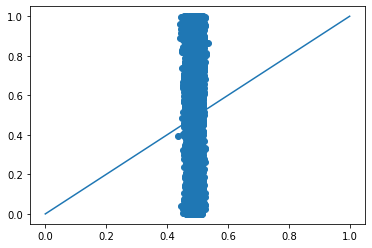

0.516306221476445 0.8172086793042107


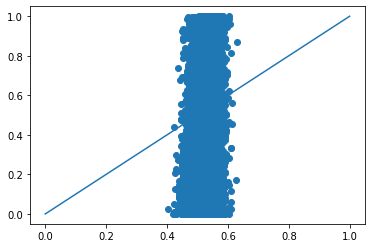

0.586232320566214 0.8172086793042107


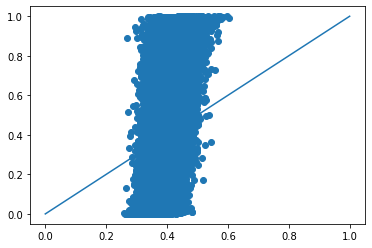

0.6474486376390857 0.8172086793042107


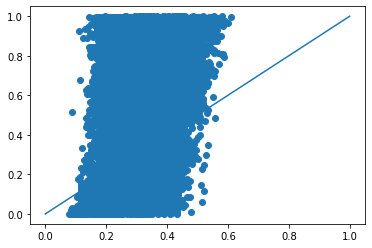

0.6263865988378428 0.8172086793042107


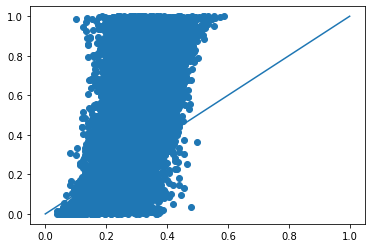

0.6862099895721465 0.8172086793042107


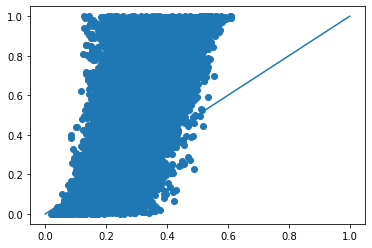

0.7025150042359125 0.8172086793042107


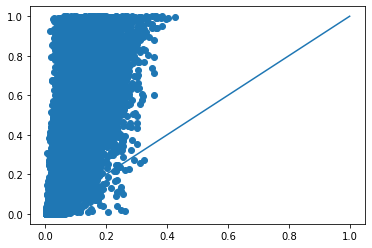

0.7127847156281482 0.8172086793042107


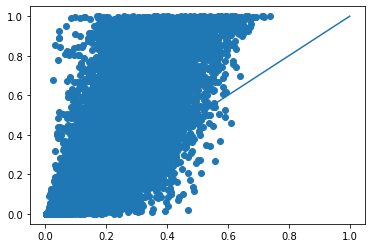

0.7234078908819153 0.8172086793042107


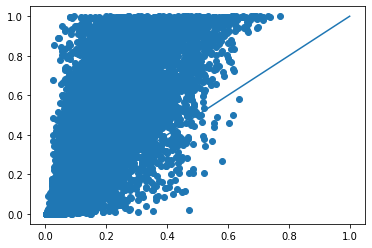

0.7324142016525794 0.8172086793042107


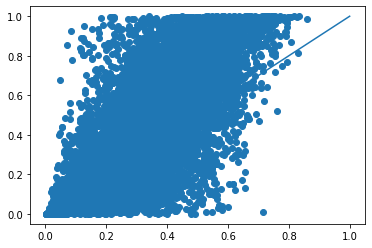

0.7350736035052982 0.8172086793042107


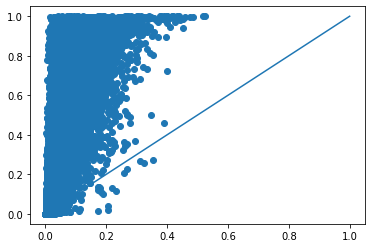

0.7310154065674216 0.8172086793042107


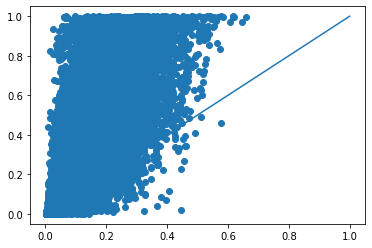

0.7052764396208968 0.8172086793042107


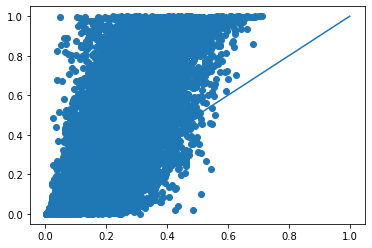

0.714909334147221 0.8172086793042107


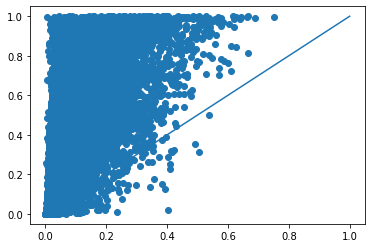

0.7160823064762627 0.8172086793042107


In [ ]:
posts = train(xPU,yPU,Lambda=1e-2,viz=True)

In [ ]:
posts,_ = getPosterior(xPU,yPU.astype(int),data.dgs[0].alpha)

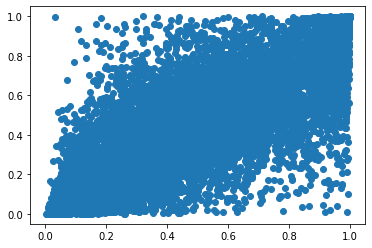

In [ ]:
plt.scatter(posts, data.dgs[0].pn_posterior_cc(xPU))
plt.plot([0,1],[0,1])

In [ ]:
roc_auc_score(yPN,posts)

0.7641765359972881